In [2]:
import pandas as pd # Data manipulation and analysis
import matplotlib.pyplot as plt #for data visualization
import seaborn as sns # Statistical data visualization
import spacy # Natural language processing library that provides pre-trained models for various languages
from spacy import displacy # Visualization of dependency parse trees and named entities
from spacy import tokenizer # Tokenization of text into words, punctuation, etc.
import re # Regular expressions for string matching and manipulation
import nltk # Natural Language Toolkit for text processing
from nltk.tokenize import word_tokenize # Tokenization of text into words
from nltk.stem import PorterStemmer, WordNetLemmatizer # Stemming and lemmatization of words
from nltk.corpus import stopwords # List of common stop words in various languages
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer # Sentiment analysis tool
import gensim # Topic modeling and document similarity analysis
import gensim.corpora as corpora  # Corpus and dictionary management for topic modeling
from gensim.models.coherencemodel import CoherenceModel # Coherence model for evaluating topic models
from gensim.models import LsiModel, TfidfModel # LSI and TF-IDF models for topic modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer # Text vectorization techniques
from sklearn.model_selection import train_test_split # Splitting data into training and testing sets
from sklearn.linear_model import LogisticRegression, SGDClassifier # Classification algorithms
from sklearn.metrics import accuracy_score, classification_report # Model evaluation metrics

In [3]:
# Set plot options
plt.rcParams['figure.figsize'] = (12,8) # Set default figure size for plots
default_plot_color = '#00bfbf'

In [4]:
data = pd.read_csv('fake_news_data.csv')

In [5]:
data.head()

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            198 non-null    object
 1   text             198 non-null    object
 2   date             198 non-null    object
 3   fake_or_factual  198 non-null    object
dtypes: object(4)
memory usage: 6.3+ KB


Text(0.5, 1.0, 'Count of Article Classifications')

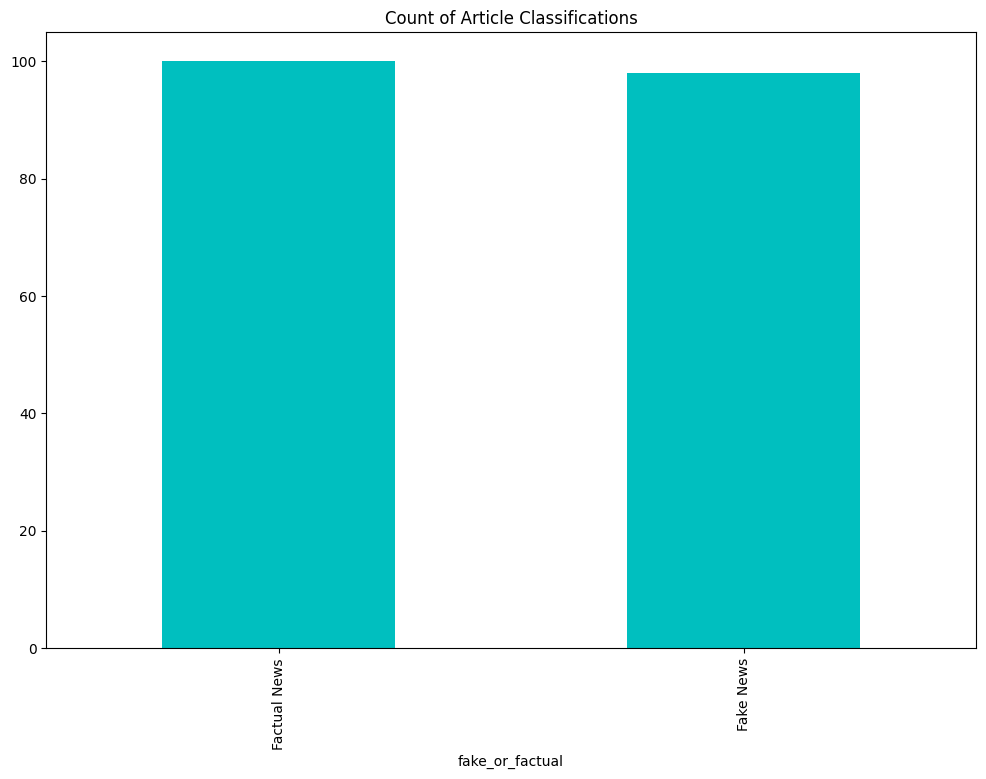

In [7]:
data['fake_or_factual'].value_counts().plot(kind='bar', color=default_plot_color)
plt.title('Count of Article Classifications')

### Pos Tagging

In [8]:
nlp = spacy.load('en_core_web_sm') # Load the small English model from spaCy to use for NLP tasks

In [9]:
fake_news = data[data['fake_or_factual'] == 'Fake News']
fact_news = data[data['fake_or_factual'] == 'Factual News']

In [10]:
# Generate spaCy documents for fake and factual news articles
fake_spacy_docs = list(nlp.pipe(fake_news['text']))
fact_spacy_docs = list(nlp.pipe(fact_news['text']))

In [11]:
def extract_token_tags(doc: spacy.tokens.doc.Doc): #doc: spacy.tokens.doc.Doc means the input 'doc' is of type spacy.tokens.doc.Doc
    return [(i.text, i.ent_type_, i.pos_) for i in doc]

In [12]:
fake_tags_df = []
columns = ['token', 'ner_tag', 'pos_tag']

In [13]:
for ix, doc in enumerate(fake_spacy_docs):
    token_tags = extract_token_tags(doc)
    temp_df = pd.DataFrame(token_tags, columns=columns)
    fake_tags_df.append(temp_df)
    
# what is happening here is that we are iterating through each document in fake_spacy_docs, extracting token tags using the extract_token_tags function, creating a temporary DataFrame (temp_df) for each document with columns 'token', 'ner_tag', and 'pos_tag', and appending this temporary DataFrame to the fake_tags_df list.

In [14]:
fake_tags_df = pd.concat(fake_tags_df)

In [15]:
fact_tags_df = []
for ix, doc in enumerate(fact_spacy_docs):
    token_tags = extract_token_tags(doc)
    temp_df = pd.DataFrame(token_tags, columns=columns)
    fact_tags_df.append(temp_df)

In [16]:
fact_tags_df = pd.concat(fact_tags_df)

In [17]:
fake_tags_df.head(20)

,token,ner_tag,pos_tag
0,There,,PRON
1,are,,VERB
2,two,CARDINAL,NUM
3,small,,ADJ
4,problems,,NOUN
5,with,,ADP
6,your,,PRON
7,analogy,,NOUN
8,Susan,PERSON,PROPN
9,,PERSON,SPACE


In [18]:
pos_counts_fake = fake_tags_df.groupby(['token', 'pos_tag']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)
pos_counts_fake.head(10)

,token,pos_tag,counts
29,",",PUNCT,1908
7451,the,DET,1834
41,.,PUNCT,1530
5766,of,ADP,922
2665,and,CCONJ,875
2449,a,DET,805
0,,SPACE,795
7528,to,PART,767
4921,in,ADP,668
5099,is,AUX,419


In [19]:
fact_tags_df.head(20)

,token,ner_tag,pos_tag
0,WASHINGTON,GPE,PROPN
1,(,,PUNCT
2,Reuters,ORG,PROPN
3,),,PUNCT
4,-,,PUNCT
5,U.S.,GPE,PROPN
6,Defense,,PROPN
7,Secretary,,PROPN
8,Jim,PERSON,PROPN
9,Mattis,PERSON,PROPN


In [20]:
pos_counts_fact = fact_tags_df.groupby(['token', 'pos_tag']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)
pos_counts_fake.head(10)

,token,pos_tag,counts
29,",",PUNCT,1908
7451,the,DET,1834
41,.,PUNCT,1530
5766,of,ADP,922
2665,and,CCONJ,875
2449,a,DET,805
0,,SPACE,795
7528,to,PART,767
4921,in,ADP,668
5099,is,AUX,419


In [21]:
pos_counts_fake.groupby('pos_tag')['token'].count().sort_values(ascending=False) 

pos_tag
NOUN     2586
VERB     1817
PROPN    1672
ADJ       882
ADV       413
NUM       221
PRON       96
ADP        89
AUX        62
SCONJ      51
DET        42
INTJ       24
PUNCT      23
CCONJ      19
X          14
PART       10
SYM         5
SPACE       3
Name: token, dtype: int64

In [22]:
pos_counts_fact.groupby('pos_tag')['token'].count().sort_values(ascending=False)

pos_tag
NOUN     2179
VERB     1539
PROPN    1379
ADJ       747
ADV       263
NUM       205
PRON       79
ADP        70
AUX        43
SCONJ      42
DET        36
PUNCT      22
SPACE      11
CCONJ      11
X          10
INTJ        7
PART        7
SYM         4
Name: token, dtype: int64

In [23]:
pos_counts_fake[pos_counts_fake.pos_tag == 'NOUN'][:15]

,token,pos_tag,counts
5981,people,NOUN,77
7349,t,NOUN,65
6216,president,NOUN,58
7960,women,NOUN,55
7516,time,NOUN,52
3138,campaign,NOUN,44
8011,year,NOUN,44
4581,government,NOUN,41
5213,law,NOUN,40
8013,years,NOUN,40


In [24]:
pos_counts_fact[pos_counts_fact.pos_tag == 'NOUN'][:15]

,token,pos_tag,counts
3738,government,NOUN,71
6618,year,NOUN,64
5901,state,NOUN,57
2360,bill,NOUN,55
1975,administration,NOUN,51
5066,president,NOUN,49
3277,election,NOUN,48
4919,people,NOUN,45
4786,order,NOUN,45
4259,law,NOUN,42


### Named Entities

In [25]:
top_entities_fake = fake_tags_df[fake_tags_df['ner_tag'] != ""].groupby(['token', 'ner_tag']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)
top_entities_fake.head(15)

,token,ner_tag,counts
1730,Trump,PERSON,154
1729,Trump,ORG,152
2129,the,ORG,121
592,Clinton,PERSON,118
718,Donald,PERSON,75
890,Hillary,PERSON,64
1329,Obama,PERSON,59
1179,McCain,PERSON,53
2167,year,DATE,44
1662,Syria,GPE,42


In [26]:
top_entities_fact = fact_tags_df[fact_tags_df['ner_tag'] != ""].groupby(['token', 'ner_tag']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)
top_entities_fact.head(15)

,token,ner_tag,counts
1968,the,ORG,159
1633,U.S.,GPE,138
1373,Reuters,ORG,131
1615,Trump,PERSON,125
1614,Trump,ORG,124
882,House,ORG,67
1997,year,DATE,63
1646,United,GPE,59
1965,the,GPE,59
1254,Obama,PERSON,55


In [27]:
ner_palette = {
    'ORG': sns.color_palette("Set2").as_hex()[0],
    'GPE': sns.color_palette("Set2").as_hex()[1],
    'NORP': sns.color_palette("Set2").as_hex()[2],
    'PERSON': sns.color_palette("Set2").as_hex()[3],
    'DATE': sns.color_palette("Set2").as_hex()[4],
    'CARDINAL': sns.color_palette("Set2").as_hex()[5],
    'PERCENT': sns.color_palette("Set2").as_hex()[6],
}
# this code creates a dictionary called ner_palette that maps specific named entity recognition (NER) tags to colors from the "Set2" color palette in seaborn. Each NER tag is assigned a unique color represented in hexadecimal format. this helps in visualizing different types of named entities with distinct colors in plots or visualizations.

[Text(0.5, 1.0, 'Top Named Entities in Fake News Articles')]

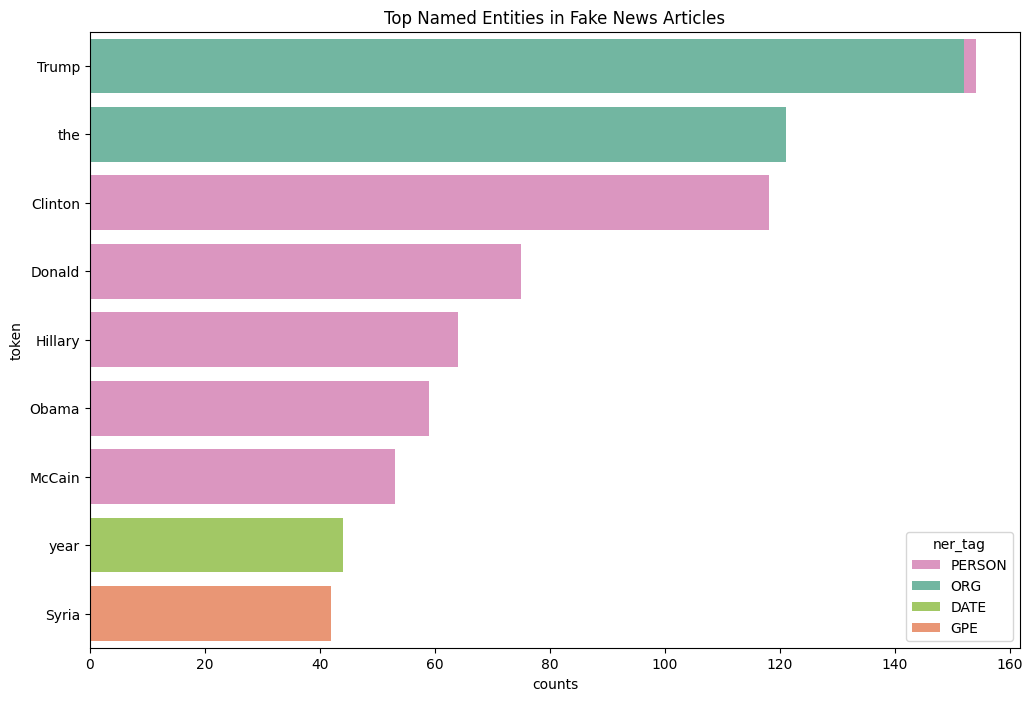

In [28]:
sns.barplot(
    x = 'counts',
    y = 'token',
    hue = 'ner_tag',
    palette = ner_palette,
    data = top_entities_fake[:10],
    orient = 'h',
    dodge = False
).set(title = 'Top Named Entities in Fake News Articles')

[Text(0.5, 1.0, 'Top Named Entities in Factual News Articles')]

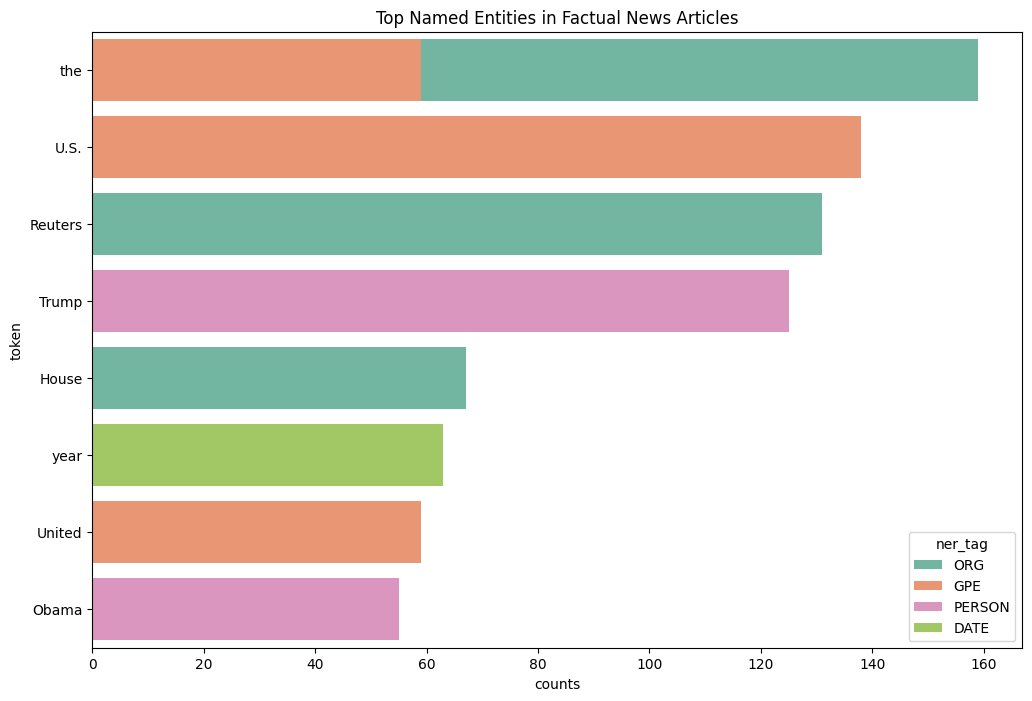

In [29]:
sns.barplot(
    x = 'counts',
    y = 'token',
    hue = 'ner_tag',
    palette = ner_palette,
    data = top_entities_fact[:10],
    orient = 'h',
    dodge = False
).set(title = 'Top Named Entities in Factual News Articles')

### Text Pre-processing

In [30]:
data.head()

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News


In [31]:
data['text_clean'] = data.apply(lambda x: re.sub(r"^[^-]*-\s", "", x['text']), axis=1) # This code creates a new column 'text_clean' in the DataFrame 'data' by applying a lambda function to each row. The lambda function uses a regular expression to remove any leading text that appears before and including the first hyphen followed by a space ("- "). This is often used to clean up text data by removing unwanted prefixes or headers from the 'text' column. here, in this case, Place names like "Washington, Belfast - " are being removed from the beginning of news articles.

In [32]:
#lowercasing and removing punctuation
data['text_clean'] = data['text_clean'].str.lower().apply(lambda x: re.sub(r'[^\w\s]', '', x))

In [33]:
en_stopwords = stopwords.words('english')
print(en_stopwords)

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

In [34]:
#remove stopwords
data['text_clean'] = data['text_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in en_stopwords]))

In [35]:
#tokenize
data['text_clean'] = data['text_clean'].apply(lambda x: word_tokenize(x))

In [36]:
#Lemmatization
lemmatizer = WordNetLemmatizer()
data['text_clean'] = data['text_clean'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

In [37]:
token_clean = sum(data['text_clean'], []) #this will join all individual lists of tokens into a single list

In [38]:
unigrams = (pd.Series(nltk.ngrams(token_clean, 1)).value_counts()).reset_index()[:10]
print(unigrams)

           index  count
0        (said,)    580
1       (trump,)    580
2           (u,)    277
3       (state,)    275
4   (president,)    259
5       (would,)    226
6         (one,)    160
7     (clinton,)    141
8        (year,)    139
9  (republican,)    137


C:\Users\ghina\AppData\Local\Temp\ipykernel_13232\3998741876.py:3: UserWarning: 
The palette list has fewer values (1) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x = 'count',


[Text(0.5, 1.0, 'Top 10 Unigrams in News Articles')]

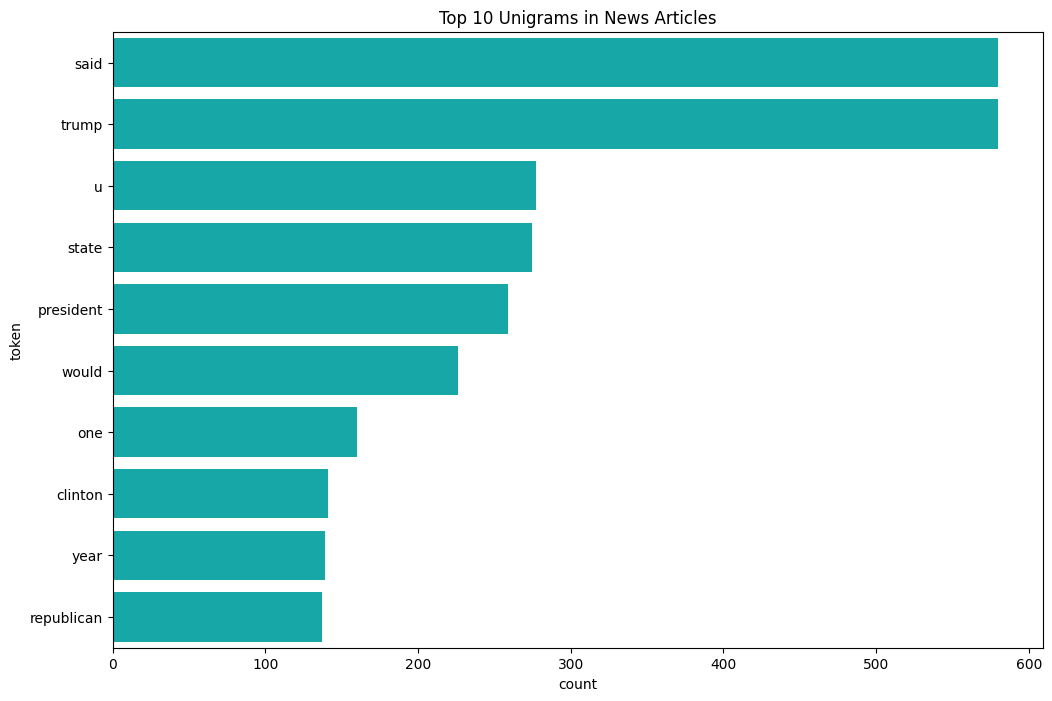

In [39]:
unigrams['token'] = unigrams['index'].apply(lambda x: x[0]) #this line creates a new column 'token' in the unigrams DataFrame by extracting the first element from each tuple in the 'index' column, which contains 1-gram tuples. this is donre to convert the 1-gram tuples into a more readable format by isolating the actual token (word) from the tuple structure.

sns.barplot(x = 'count',
            y = 'token',
            data = unigrams,
            orient = 'h',
            palette = [default_plot_color],
            hue = 'token',
            legend = False).set(title = 'Top 10 Unigrams in News Articles')

In [40]:
bigrams = (pd.Series(nltk.ngrams(token_clean, 2)).value_counts()).reset_index()[:10]
print(bigrams)

                     index  count
0          (donald, trump)    113
1          (united, state)     84
2           (white, house)     74
3      (president, donald)     47
4       (hillary, clinton)     39
5              (new, york)     33
6         (supreme, court)     30
7             (image, via)     29
8         (official, said)     26
9  (trump, administration)     26


C:\Users\ghina\AppData\Local\Temp\ipykernel_13232\3229897935.py:3: UserWarning: 
The palette list has fewer values (1) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x = 'count',


[Text(0.5, 1.0, 'Top 10 Biigrams in News Articles')]

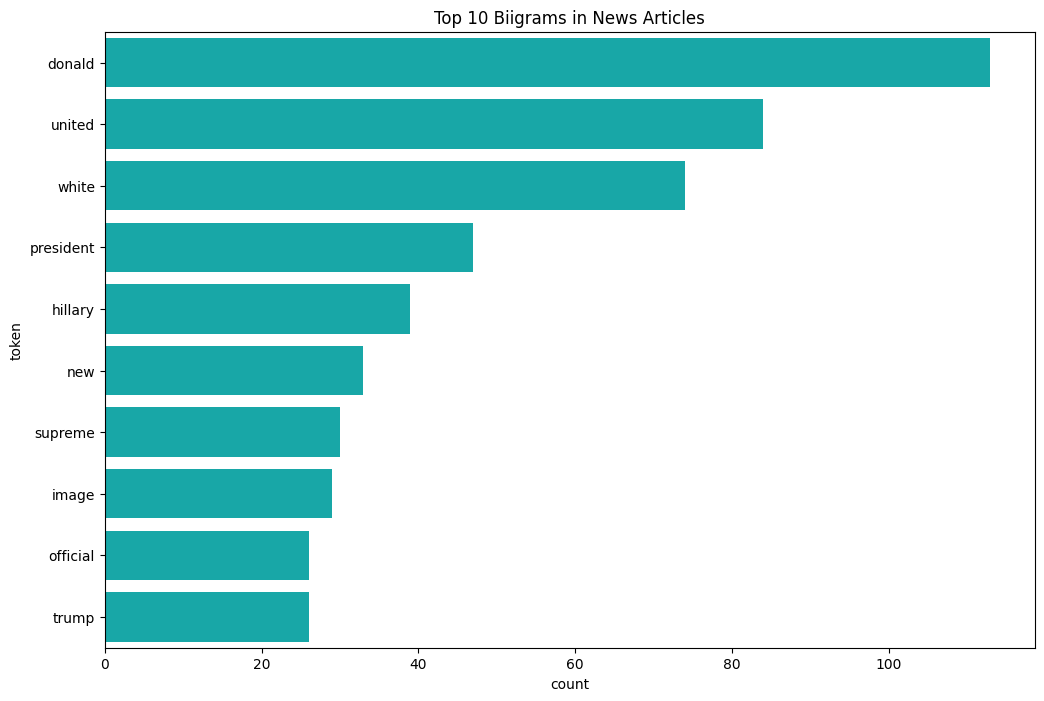

In [41]:
bigrams['token'] = bigrams['index'].apply(lambda x: x[0]) 

sns.barplot(x = 'count',
            y = 'token',
            data = bigrams,
            orient = 'h',
            palette = [default_plot_color],
            hue = 'token',
            legend = False).set(title = 'Top 10 Biigrams in News Articles')

### Sentiment Analysis

In [42]:
vader_sentiment = SentimentIntensityAnalyzer()

In [43]:
# Calculate VADER sentiment scores
data['vader_sentiment_score'] = data['text'].apply(lambda x: vader_sentiment.polarity_scores(x)['compound'])

In [44]:
data.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[two, small, problem, analogy, susan, jesus, m...",-0.3660
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9779
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590


In [45]:
# Create sentiment labels based on VADER scores
bins = [-1.0, -0.1, 0.1, 1.0]
names = ['Negative', 'Neutral', 'Positive']

In [46]:
# Create sentiment labels based on VADER scores 
data['vader_sentiment_label'] = pd.cut(data['vader_sentiment_score'], bins, labels=names)

In [47]:
data.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score,vader_sentiment_label
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[two, small, problem, analogy, susan, jesus, m...",-0.3660,Negative
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197,Negative
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9779,Positive
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400,Negative
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590,Positive


Text(0.5, 1.0, 'VADER Sentiment Label Counts')

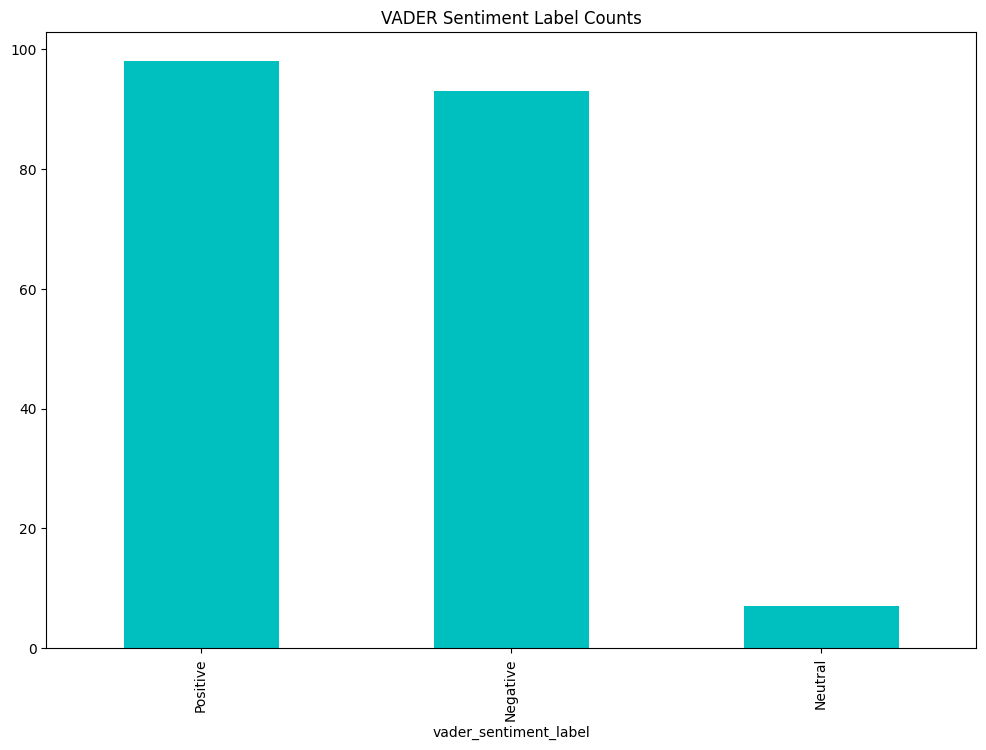

In [48]:
#plotting the bar graph
data['vader_sentiment_label'].value_counts().plot(kind='bar', color=default_plot_color)
plt.title('VADER Sentiment Label Counts')

C:\Users\ghina\AppData\Local\Temp\ipykernel_13232\3449745357.py:1: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.countplot(


[Text(0.5, 1.0, 'VADER Sentiment Labels by Article Classification')]

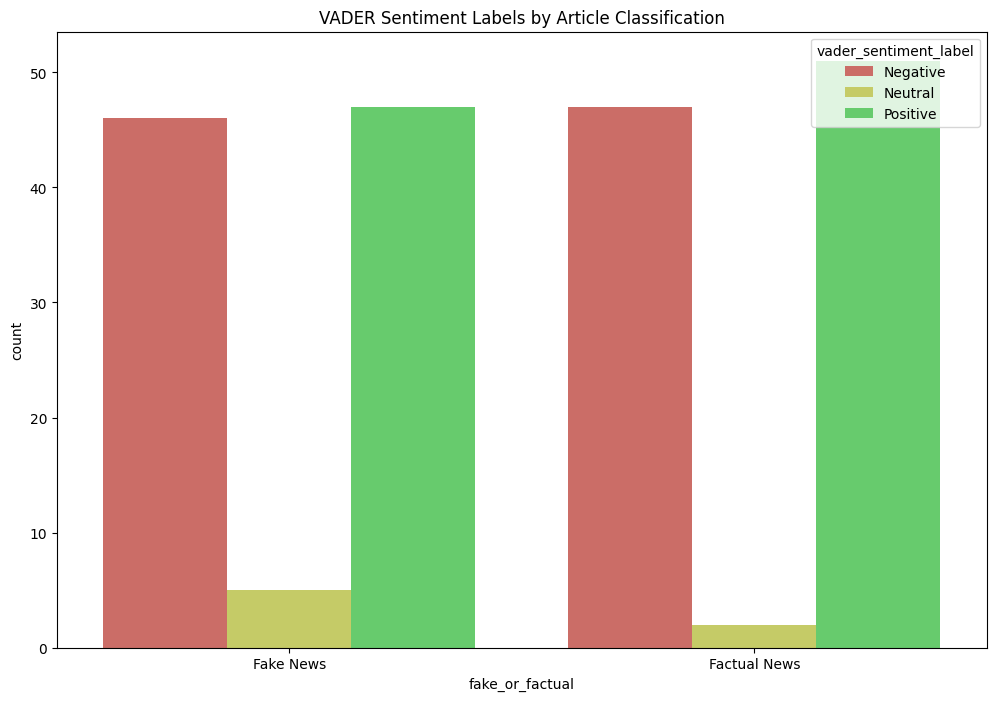

In [49]:
sns.countplot(
    x = 'fake_or_factual',
    hue = 'vader_sentiment_label',
    data = data,
    palette = sns.color_palette("hls")
).set(title='VADER Sentiment Labels by Article Classification')

### Topic Modeling

In [ ]:
fake_news_text = data[data['fake_or_factual'] == 'Fake News']['text_clean'].reset_index(drop=True)

In [51]:
dictionary_fake = corpora.Dictionary(fake_news_text)

In [52]:
doc_term_fake = [dictionary_fake.doc2bow(text) for text in fake_news_text]

In [53]:
coherence_values = []
model_list = []

min_topics = 2
max_topics = 11

for num_topics_i in range(min_topics, max_topics+1):
    model = gensim.models.LdaModel(doc_term_fake, num_topics = num_topics_i, id2word = dictionary_fake)
    model_list.append(model)
    coherence_model = CoherenceModel(model=model, texts=fake_news_text, dictionary=dictionary_fake, coherence='c_v')
    coherence_values.append(coherence_model.get_coherence())
    

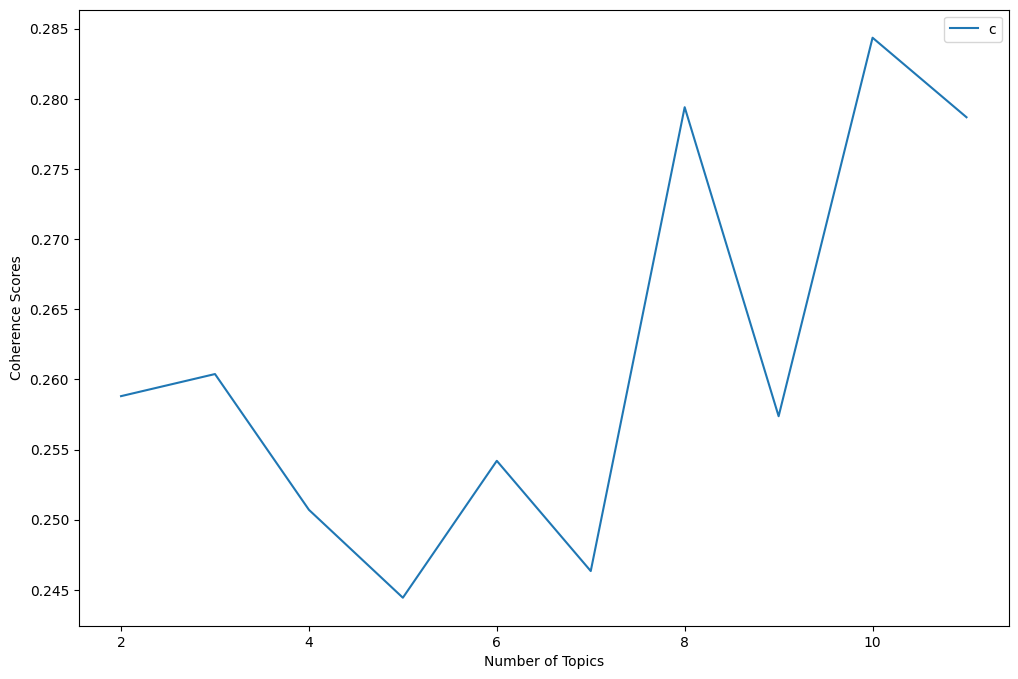

In [58]:
plt.plot(range(min_topics, max_topics+1), coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Scores")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [59]:
num_topics_lda = 7
lda_model = gensim.models.LdaModel(corpus=doc_term_fake, id2word=dictionary_fake, num_topics=num_topics_lda)

In [61]:
lda_model.print_topics(num_topics = num_topics_lda, num_words=10)

[(0,
  '0.006*"trump" + 0.005*"u" + 0.004*"said" + 0.004*"american" + 0.004*"state" + 0.004*"mccain" + 0.003*"clinton" + 0.003*"go" + 0.003*"syria" + 0.003*"woman"'),
 (1,
  '0.013*"trump" + 0.006*"said" + 0.005*"president" + 0.005*"donald" + 0.004*"clinton" + 0.004*"time" + 0.004*"one" + 0.003*"state" + 0.003*"two" + 0.003*"news"'),
 (2,
  '0.013*"trump" + 0.004*"clinton" + 0.004*"president" + 0.004*"hillary" + 0.004*"u" + 0.003*"state" + 0.003*"official" + 0.003*"time" + 0.003*"would" + 0.003*"obama"'),
 (3,
  '0.010*"trump" + 0.005*"u" + 0.004*"would" + 0.004*"president" + 0.004*"said" + 0.004*"one" + 0.003*"time" + 0.003*"state" + 0.003*"year" + 0.003*"american"'),
 (4,
  '0.013*"trump" + 0.006*"said" + 0.006*"republican" + 0.006*"clinton" + 0.005*"president" + 0.004*"would" + 0.004*"one" + 0.004*"state" + 0.003*"donald" + 0.003*"hillary"'),
 (5,
  '0.010*"trump" + 0.005*"state" + 0.005*"said" + 0.005*"clinton" + 0.004*"would" + 0.003*"one" + 0.003*"people" + 0.003*"president" + 0.

In [62]:
def tfidf_corpus(doc_term_matrix):
    tfidf = TfidfModel(corpus=doc_term_matrix, normalize=True)
    corpus_tfidf = tfidf[doc_term_matrix]
    return corpus_tfidf

In [63]:
def get_coherence_scores(corpus, dictionary, text, min_topics, max_topics):
    coherence_values = []
    model_list = []
    for num_topics_i in range(min_topics, max_topics+1):
        model = LsiModel(corpus, num_topics=num_topics_i, id2word=dictionary)
        coherence_model = CoherenceModel(model = model, texts=text, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
        
    plt.plot(range(min_topics, max_topics+1), coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence Scores")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

In [64]:
corpus_tfidf_fake = tfidf_corpus(doc_term_fake)

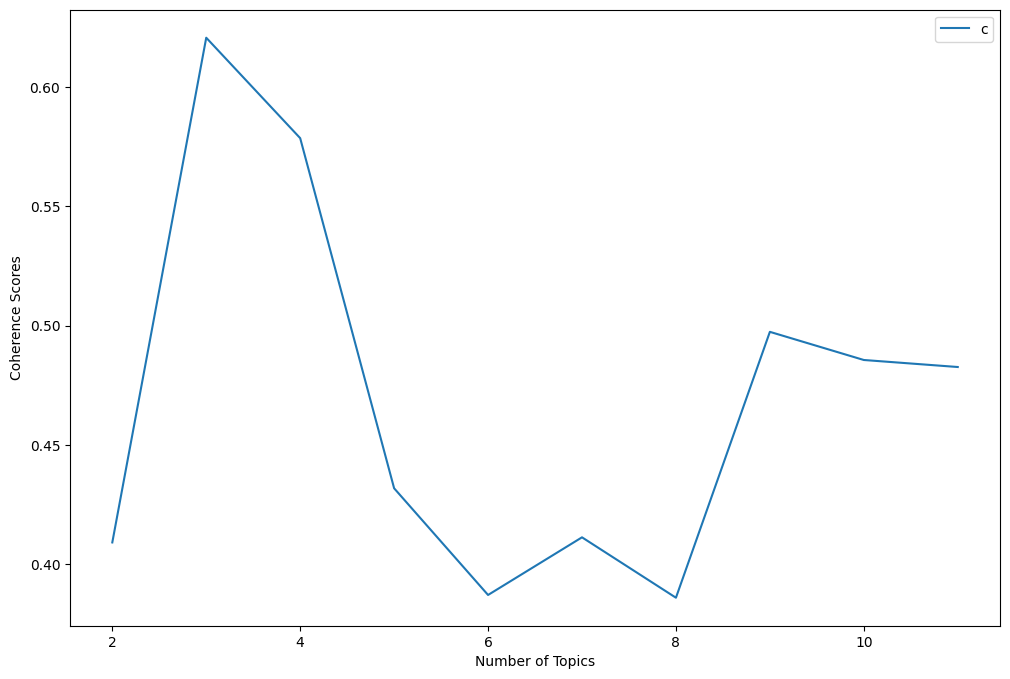

In [66]:
get_coherence_scores(corpus_tfidf_fake, dictionary_fake, fake_news_text, min_topics=2, max_topics=11)

In [67]:
lsa_model = LsiModel(corpus_tfidf_fake, id2word=dictionary_fake, num_topics=7)

In [68]:
lsa_model.print_topics()

[(0,
  '0.190*"trump" + 0.136*"clinton" + 0.095*"hillary" + 0.094*"obama" + 0.089*"president" + 0.087*"woman" + 0.078*"republican" + 0.077*"party" + 0.077*"flynn" + 0.074*"candidate"'),
 (1,
  '-0.325*"boiler" + -0.284*"acr" + -0.244*"room" + -0.240*"pm" + -0.186*"broadcast" + -0.180*"radio" + -0.142*"tune" + -0.142*"animal" + -0.134*"jay" + -0.132*"episode"'),
 (2,
  '0.623*"flynn" + 0.182*"immunity" + 0.122*"nana" + 0.116*"mr" + 0.110*"30" + 0.108*"march" + 0.102*"russian" + 0.100*"source" + -0.095*"school" + 0.092*"adviser"'),
 (3,
  '-0.217*"clinton" + 0.186*"school" + 0.176*"student" + -0.141*"hillary" + 0.121*"county" + 0.121*"flynn" + -0.110*"sander" + -0.098*"debate" + -0.097*"woman" + -0.091*"nominee"'),
 (4,
  '-0.200*"email" + 0.194*"trump" + -0.168*"dnc" + 0.142*"flynn" + -0.126*"clinton" + 0.112*"cruz" + -0.111*"department" + -0.110*"rich" + -0.102*"wikileaks" + -0.099*"sander"'),
 (5,
  '0.276*"student" + 0.160*"conference" + 0.160*"school" + 0.137*"trump" + -0.125*"mccai

### Creating our Classification Model

In [69]:
data.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score,vader_sentiment_label
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[two, small, problem, analogy, susan, jesus, m...",-0.3660,Negative
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197,Negative
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9779,Positive
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400,Negative
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590,Positive


In [70]:
X = [','.join(map(str,l)) for l in data['text_clean']]

In [71]:
y = data['fake_or_factual']

In [73]:
countvec = CountVectorizer()

In [75]:
countvec_fit = countvec.fit_transform(X)

In [77]:
bag_of_words = pd.DataFrame(countvec_fit.toarray(), columns=countvec.get_feature_names_out())

In [78]:
X_train, X_test, y_train, y_test = train_test_split(bag_of_words, y, test_size=0.3)

In [79]:
lr = LogisticRegression(random_state=0).fit(X_train, y_train)

In [80]:
y_pred_lr = lr.predict(X_test)

In [81]:
accuracy_score(y_pred_lr, y_test)

0.9166666666666666

In [82]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

Factual News       0.93      0.90      0.91        29
   Fake News       0.91      0.94      0.92        31

    accuracy                           0.92        60
   macro avg       0.92      0.92      0.92        60
weighted avg       0.92      0.92      0.92        60



In [83]:
svm = SGDClassifier().fit(X_train, y_train)

In [84]:
y_pred_svm = svm.predict(X_test)

In [85]:
accuracy_score(y_pred_svm, y_test)

0.9166666666666666

In [86]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

Factual News       0.96      0.86      0.91        29
   Fake News       0.88      0.97      0.92        31

    accuracy                           0.92        60
   macro avg       0.92      0.91      0.92        60
weighted avg       0.92      0.92      0.92        60

